# Data Setup

In [2]:
!ls

README.md                     requirements.txt
data                          ts-hf-periodic-refactor.ipynb
environment.yaml              weights
examine_and_clean_macho.ipynb


In [3]:
import os
print(os.environ.get('CONDA_DEFAULT_ENV'))
os.environ.update({"PYTORCH_ENABLE_MPS_FALLBACK": "1"})

multi_modal


In [4]:
import joblib
import os
import numpy as np
import torch
from evaluate import load
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import PretrainedConfig
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(f"{torch.__version__=}")
print(f"{transformers.__version__=}")

torch.__version__='2.1.0'
transformers.__version__='4.35.0'


In [127]:
class MachoDataset(Dataset):
    def __init__(self, data_root, prediction_length, mode='train', use_errors=True):
        data = joblib.load(data_root + f'{mode}.pkl')
        self.data = data
        self.prediction_length = prediction_length
        self.use_errors = use_errors
        
        if use_errors and data[0][:, :, :].shape[1] != 3:
            raise Exception("use_errors was True but dataset does not contain errors."
                            " Try running preprocess_data.py with the flag --use-error")

        self.times = data[0][:, 0, :]
        if use_errors:
            self.values = data[0][:, 1:, :]
        else:
            self.values = data[0][:, 1, :]
        
        self.aux = data[1]
        self.labels = data[2]
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        past_times = torch.tensor(self.times[idx, :-self.prediction_length], dtype=torch.float)
        future_times = torch.tensor(self.times[idx, -self.prediction_length:], dtype=torch.float)
        if use_errors:
            past_values = torch.tensor(self.values[idx, :, :-self.prediction_length], dtype=torch.float)
            future_values = torch.tensor(self.values[idx, :, -self.prediction_length:], dtype=torch.float)        
        else:
            past_values = torch.tensor(self.values[idx, :-self.prediction_length], dtype=torch.float)
            future_values = torch.tensor(self.values[idx, -self.prediction_length:], dtype=torch.float)       
        
        past_mask = torch.ones(past_times.shape, dtype=torch.float)
        future_mask = torch.ones(future_times.shape, dtype=torch.float)
        labels = torch.tensor(self.labels[idx], dtype=torch.long)

        past_times = past_times.unsqueeze(-1)
        future_times = future_times.unsqueeze(-1)

        return past_times, future_times, past_values, future_values, past_mask, future_mask, labels

In [128]:
data_root = './data/data/macho/'
window_length = 200
prediction_length = 50

In [129]:
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"device: {device}")

device: mps


In [130]:
data = joblib.load(data_root + f'train.pkl')

In [131]:
use_errors = False
train_dataset = MachoDataset(data_root, prediction_length, mode='train', use_errors=use_errors)
val_dataset = MachoDataset(data_root, prediction_length, mode='val', use_errors=use_errors)
test_dataset = MachoDataset(data_root, prediction_length, mode='test', use_errors=use_errors)

In [132]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [133]:
past_times, future_times, past_values, future_values, past_mask, future_mask, labels = train_dataset[10]

In [134]:
past_times.shape, past_values.shape

(torch.Size([150, 1]), torch.Size([150]))

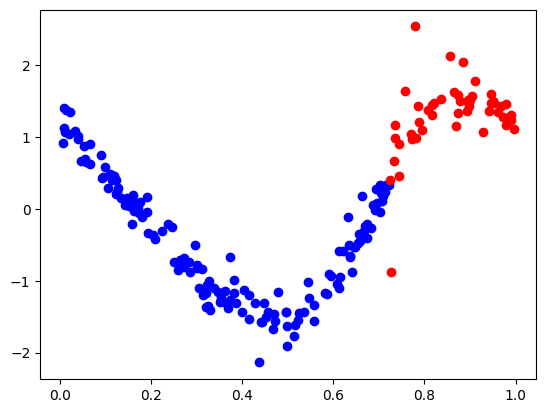

In [135]:
if use_errors:
    plt.errorbar(past_times, past_values[0,:], past_values[1,:], fmt="o")
    plt.errorbar(future_times, future_values[0,:], future_values[1,:], fmt="o", c="r")
else:
    plt.scatter(past_times, past_values, c="b")
    plt.scatter(future_times, future_values, c="r")  


# Time Series Prediction Model Setup

In [136]:
def train_step(train_dataloader, model, optimizer):
    total_loss = []
    
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()

        past_times, future_times, past_values, future_values, past_mask, future_mask, _ = batch
        
        outputs = model(
            past_time_features=past_times.to(device),
            past_values=past_values.to(device),
            future_time_features=future_times.to(device),
            future_values=future_values.to(device),
            past_observed_mask=past_mask.to(device),
            future_observed_mask=future_mask.to(device),
        )

        loss = outputs.loss
        total_loss.append(loss.item())

        loss.backward()
        optimizer.step()

    return sum(total_loss) / len(total_loss)

In [137]:
def val_step(val_dataloader, model):
    total_loss = []

    for idx, batch in enumerate(val_dataloader):
        with torch.no_grad():
            past_times, future_times, past_values, future_values, past_mask, future_mask, _ = batch
            
            outputs = model(
                past_time_features=past_times.to(device),
                past_values=past_values.to(device),
                future_time_features=future_times.to(device),
                future_values=future_values.to(device),
                past_observed_mask=past_mask.to(device),
                future_observed_mask=future_mask.to(device),
            )
        
            loss = outputs.loss
            total_loss.append(loss.item())
            
    return sum(total_loss) / len(total_loss)

In [138]:
config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    context_length=window_length - prediction_length - 7,    # 7 is max(lags) for default lags
    num_time_features=1,
    encoder_layers=2,
    decoder_layers=2,
    d_model=64,
    input_size = 1 if not use_errors else 2
)

model = TimeSeriesTransformerForPrediction(config)

In [139]:
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

In [140]:
train_losses, val_losses = [], []

for epoch in range(10):
    model.train()
    train_loss = train_step(train_dataloader, model, optimizer)
    train_losses.append(train_loss)

    model.eval()
    val_loss = val_step(val_dataloader, model)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch}: Train Loss {round(train_loss, 4)} Val Loss {round(val_loss, 4)}')

/Users/jbloom/miniforge3/envs/multi_modal/lib/python3.10/site-packages/torch/distributions/studentT.py:98: UserWarning: The operator 'aten::lgamma.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  + torch.lgamma(0.5 * self.df)


Epoch 0: Train Loss 1.6539 Val Loss 1.5214
Epoch 1: Train Loss 1.5073 Val Loss 1.4448
Epoch 2: Train Loss 1.4563 Val Loss 1.4038
Epoch 3: Train Loss 1.4325 Val Loss 1.3875
Epoch 4: Train Loss 1.4117 Val Loss 1.3757
Epoch 5: Train Loss 1.3961 Val Loss 1.3634
Epoch 6: Train Loss 1.3905 Val Loss 1.3443
Epoch 7: Train Loss 1.3798 Val Loss 1.3429
Epoch 8: Train Loss 1.3718 Val Loss 1.3379
Epoch 9: Train Loss 1.3746 Val Loss 1.3388


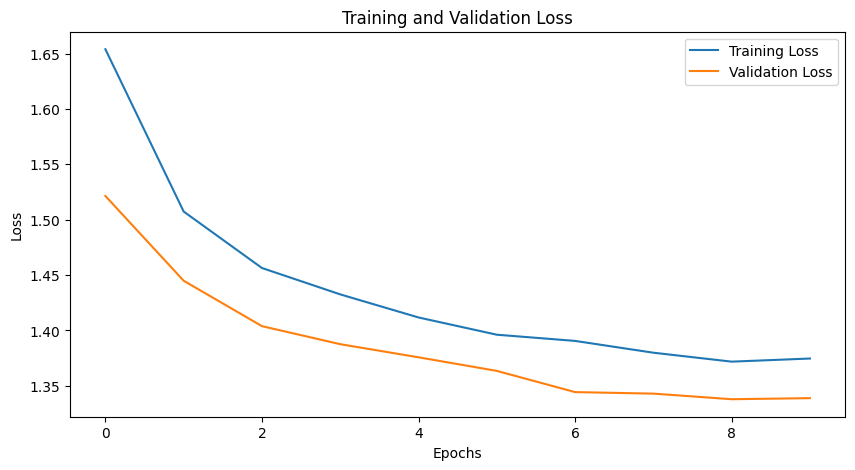

In [141]:
epochs = range(10)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [142]:
model.save_pretrained('weights/model.ckpt')

# Time Series Prediction Model Evaluation

In [143]:
def get_forecasts(model, val_dataloader):
    forecasts = []

    for idx, batch in enumerate(val_dataloader):
        with torch.no_grad():
            past_times, future_times, past_values, future_values, past_mask, future_mask, label = batch
            
            outputs = model.generate(
                past_time_features=past_times.to(device),
                past_values=past_values.to(device),
                future_time_features=future_times.to(device),
                past_observed_mask=past_mask.to(device),
            )
            
            forecasts.append(outputs.sequences.cpu().numpy())
    
    forecasts = np.vstack(forecasts)
    forecast_median = np.median(forecasts, 1)

    return forecast_median

In [144]:
def get_metrics(val_dataset, forecasts):
    mase_metric = load('evaluate-metric/mase')
    smape_metric = load('evaluate-metric/smape')
    
    mase_metrics = []
    smape_metrics = []
    
    for i, ts in enumerate(tqdm(val_dataset)):
        _, _, past_values, future_values, _, _, _ = val_dataset[i]
    
        mase = mase_metric.compute(
            predictions=forecasts[i],
            references=np.array(future_values),
            training=np.array(past_values)
        )
        mase_metrics.append(mase['mase'])
    
        smape = smape_metric.compute(
            predictions=forecasts[i],
            references=np.array(future_values),
        )
        smape_metrics.append(smape['smape'])

    return np.mean(mase_metrics), np.mean(smape_metrics)

In [145]:
model = TimeSeriesTransformerForPrediction.from_pretrained('weights/model.ckpt')
model = model.to(device)

In [146]:
model.eval()

forecasts = get_forecasts(model, val_dataloader)
mase, smape = get_metrics(val_dataset, forecasts)

print(f'MASE: {mase} sMAPE: {smape}')

KeyboardInterrupt: 

# Classification Model

In [148]:
class ClassificationModel(nn.Module):
    def __init__(self, pretrained_model_path, device, hidden_size=64, num_labels=8):
        super(ClassificationModel, self).__init__()

        self.pretrained_model = TimeSeriesTransformerForPrediction.from_pretrained(pretrained_model_path)
        self.pretrained_model.to(device)
        self.device = device
        
        # for param in self.pretrained_model.parameters():
        #     param.requires_grad = False
            
        self.classifier = nn.Linear(hidden_size, num_labels)
        self.classifier.to(self.device)
        
    def forward(self, past_times, past_values, future_times, past_mask):   
        outputs = self.pretrained_model(
            past_time_features=past_times.to(self.device),
            past_values=past_values.to(self.device),
            future_time_features=future_times.to(self.device),
            past_observed_mask=past_mask.to(self.device),
        )
    
        # embedding = torch.mean(outputs.encoder_last_hidden_state, dim=1)        
        embedding = outputs.encoder_last_hidden_state[:, 0, :]
        logits = self.classifier(embedding)
        
        return logits

In [149]:
def cl_train_step(train_dataloader, cl_model, cl_optimizer, cl_loss):
    total_loss = []
    total_correct_predictions = 0
    total_predictions = 0

    for batch in train_dataloader:
        past_times, future_times, past_values, future_values, past_mask, future_mask, labels = batch
        labels = labels.to(device)
        
        cl_optimizer.zero_grad()

        logits = cl_model(past_times, past_values, future_times, past_mask)
        loss = cl_loss(logits, labels)
        total_loss.append(loss.item())

        probabilities = torch.nn.functional.softmax(logits, dim=1)
        _, predicted_labels = torch.max(probabilities, dim=1)
        correct_predictions = (predicted_labels == labels).sum().item()
        
        total_correct_predictions += correct_predictions
        total_predictions += labels.size(0)
        
        loss.backward()
        cl_optimizer.step()

    return sum(total_loss) / len(total_loss), total_correct_predictions / total_predictions

In [150]:
def cl_val_step(val_dataloader, cl_model, cl_loss):
    total_loss = []
    total_correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in val_dataloader:
            past_times, future_times, past_values, future_values, past_mask, future_mask, labels = batch
            labels = labels.to(device)
                
            logits = cl_model(past_times, past_values, future_times, past_mask)
            loss = cl_loss(logits, labels)
            total_loss.append(loss.item())
    
            probabilities = torch.nn.functional.softmax(logits, dim=1)
            _, predicted_labels = torch.max(probabilities, dim=1)
            correct_predictions = (predicted_labels == labels).sum().item()
            
            total_correct_predictions += correct_predictions
            total_predictions += labels.size(0)
            
    return sum(total_loss) / len(total_loss), total_correct_predictions / total_predictions

In [151]:
cl_model = ClassificationModel(pretrained_model_path='weights/model.ckpt', device=device)
cl_optimizer = AdamW(cl_model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)
cl_loss = nn.CrossEntropyLoss()

In [152]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(20):
    model.train()
    train_loss, train_acc = cl_train_step(train_dataloader, cl_model, cl_optimizer, cl_loss)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, val_acc = cl_val_step(val_dataloader, cl_model, cl_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch}: Train Loss {round(train_loss, 4)} \t Val Loss {round(val_loss, 4)} \t \
            Train Acc {round(train_acc, 4)} \t Val Acc {round(val_acc, 4)}')

Epoch 0: Train Loss 1.3076 	 Val Loss 1.1364 	             Train Acc 0.5407 	 Val Acc 0.5973
Epoch 1: Train Loss 1.0624 	 Val Loss 1.0364 	             Train Acc 0.6096 	 Val Acc 0.6202
Epoch 2: Train Loss 0.9901 	 Val Loss 0.9804 	             Train Acc 0.6324 	 Val Acc 0.637
Epoch 3: Train Loss 0.9529 	 Val Loss 0.9519 	             Train Acc 0.6425 	 Val Acc 0.6419
Epoch 4: Train Loss 0.9263 	 Val Loss 0.9287 	             Train Acc 0.6552 	 Val Acc 0.6588
Epoch 5: Train Loss 0.9057 	 Val Loss 0.9181 	             Train Acc 0.6648 	 Val Acc 0.6617
Epoch 6: Train Loss 0.8855 	 Val Loss 0.8984 	             Train Acc 0.6741 	 Val Acc 0.6719
Epoch 7: Train Loss 0.8727 	 Val Loss 0.8834 	             Train Acc 0.6824 	 Val Acc 0.6854
Epoch 8: Train Loss 0.8573 	 Val Loss 0.8882 	             Train Acc 0.6884 	 Val Acc 0.6804
Epoch 9: Train Loss 0.8467 	 Val Loss 0.8627 	             Train Acc 0.6944 	 Val Acc 0.6935
Epoch 10: Train Loss 0.8385 	 Val Loss 0.8508 	             Train Acc 0

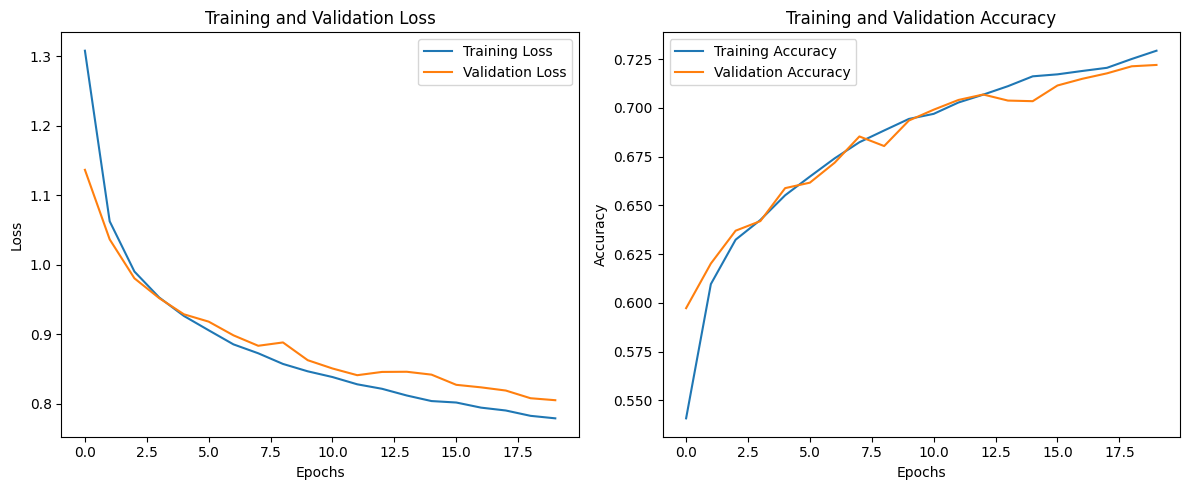

In [153]:
epochs = range(len(train_losses))

plt.figure(figsize=(12, 5))

# Plot training and validation losses
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate Classification Model

In [154]:
cl_model.eval()

all_true_labels = []
all_predicted_labels = []

for batch in val_dataloader:
    with torch.no_grad():
        past_times, future_times, past_values, future_values, past_mask, future_mask, label = batch
        label = label.to(device)
        
        logits = cl_model(past_times, past_values, future_times, past_mask)
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        _, predicted_labels = torch.max(probabilities, dim=1)

        all_true_labels.extend(label.cpu().numpy())
        all_predicted_labels.extend(predicted_labels.cpu().numpy())

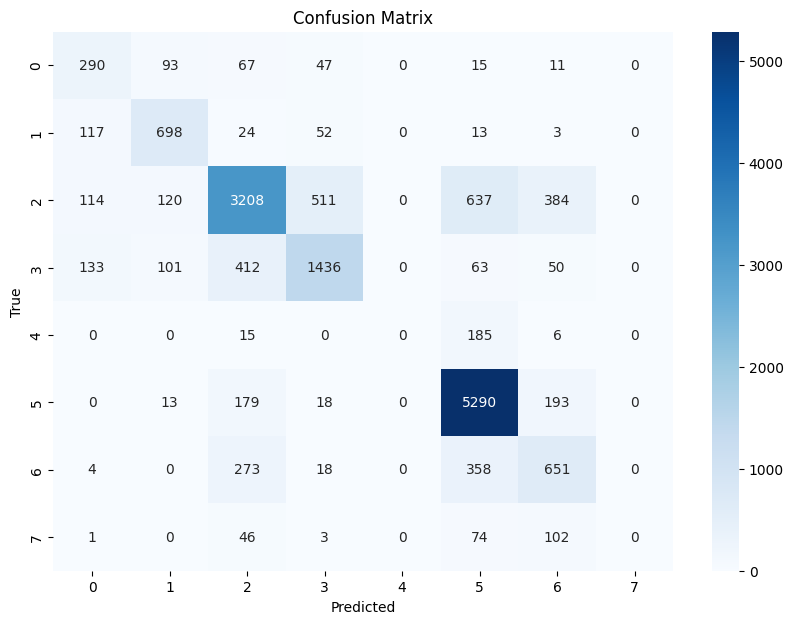

In [155]:
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()